In [1]:
from curses import raw
import os 
import os.path as osp
from pyexpat import model
import pandas as pd 
import numpy as np
import torch as th
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from glob import glob
raw_dir = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/04_POI-EV_Verification/"
model_path = osp.join(raw_dir,'yolov7')
data_path = osp.join(raw_dir,'data/evcharger_data/test')
data_yaml = osp.join(raw_dir ,'yolov7','data/data.yaml')

print("Data Yaml :",data_yaml)
print("Model Path :",model_path)

Data Yaml : /mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/04_POI-EV_Verification/yolov7/data/data.yaml
Model Path : /mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/04_POI-EV_Verification/yolov7


In [2]:
image_path = glob(data_path+'/images/*.jpg')
print("test images :",len(image_path))

test images : 4


In [3]:
def read_annotations(annotations_path,img_shape):
    with open(annotations_path, 'r') as f:
            annotations = f.read().splitlines()
    img_annot = list()
    class_ids = list()
    for annt in annotations:
        cls_id = annt[0]
        x,y = annt.split()[1:3]
        w,h = annt.split()[3:5]
        x1,y1,x2,y2= xywh2xyxy([x,y,w,h])
        x1,x2 = int(x1 * img_shape[1]),int(x2 *img_shape[1])
        y1,y2 = int(y1 * img_shape[0]),int(y2 *img_shape[0])
        
        img_annot.append([x1,y1,x2,y2])
        class_ids.append(cls_id)
    return [img_annot,class_ids]


def draw_boxes(img, img_bboxes ,color=(238, 0, 226),scale=False):
    """
    Add bounding box onto image
    img : image 
    img_bboxes: Bounding Boxes
    """
    img_cpy = deepcopy(img)
    for cords in img_bboxes:
        x1,y1,x2,y2 = cords
        cv2.rectangle(img_cpy, (x1, y1), (x2, y2), color, 3)
    if scale:
        img_cpy = cv2.resize(img_cpy,(640,640),interpolation=cv2.INTER_AREA)
    return img_cpy


def plot_boxes(img, boxes, score=None, name='Object', color=(132, 255, 0)):
    line_width = max(round(sum(img.shape) / 2 * 0.003), 2)
    if score:
        w, h = \
            cv2.getTextSize("{} {:.2f}".format(name, score), 0, fontScale=line_width / 3, thickness=max(line_width - 1, 1))[0]
    else:
        w,h = cv2.getTextSize("{}".format(name), 0, fontScale=line_width / 3, thickness=max(line_width - 1, 1))[0]
    x1, y1, x2, y2 = boxes
    # add a context line on bbox
    outside = y1 - h - 3 >= 0  # label fits outside box
    p2 = x1 + w, y1 - h - 3 if outside else y1 + h + 3
    img = cv2.rectangle(img, (x1, y1), p2, color, -1, cv2.LINE_AA)
    if score:
        text = "{} {:.2f}".format(name, score)
    else:
        text = "{}".format(name)
    img = cv2.putText(img, text,(x1, y1 - 2 if outside else y1 + h + 3), 0, line_width / 2, (255, 255, 255), 2,lineType=cv2.LINE_AA)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), color, line_width // 3, lineType=cv2.LINE_AA)
    return img

def display_images(images, columns=5, width=15, height=17, max_images=15, label_wrap_length=50, label_font_size=8):
    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]
    height = max(height, int(len(images)/columns) * height)
    
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        
        img = cv2.imread(image)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label_path = osp.dirname(image).replace('images','labels/') + osp.basename(image).replace('jpg','txt')
        
        bboxes,cls_ids = read_annotations(label_path,img.shape[:2])
        upadted_img = draw_boxes(img,bboxes,scale=True)
        
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.title("image-"+str(i+1))
        plt.tight_layout()
        plt.imshow(upadted_img)
        
def xywh2xyxy(coordinates:list()):
    x,y,w,h = np.asanyarray(coordinates,dtype=np.float32)
    x1 = x - w/2
    y1 = y - h/2
    x2 = x + w/2
    y2 = y + h/2
    return [x1,y1,x2,y2]
    

### Visualize Test Data

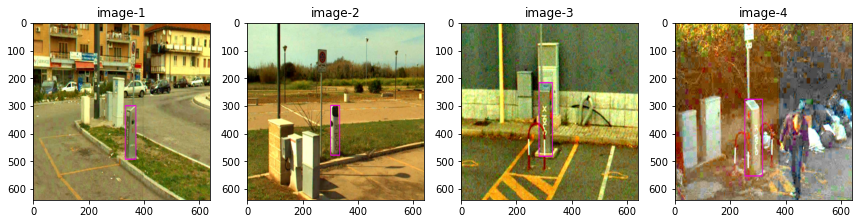

In [4]:
display_images(image_path)

## Load Model

In [5]:
import matplotlib.pyplot as plt
import torch
import os.path as osp
import cv2
import numpy as np
import time
import sys 

sys.path.append(osp.join(raw_dir,'yolov7'))

from torchvision import transforms
from utils.general import non_max_suppression
from utils.datasets import letterbox
from models.experimental import attempt_load
trained_weight = 'best.pt'
weight = osp.join(raw_dir,'yolov7',trained_weight)
show_model = False

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device running torch :",device)
# if not torch.cuda.is_available():
weigths = attempt_load(weight,map_location=device)
cls_name = weigths.names
print("class name",cls_name)

Device running torch : cpu
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
class name ['evcharger']


In [7]:
def read_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img 


def inference(model, input_image, image_size=640, confidence=0.7, iou_thresh=0.5,device='cpu'):
    detections = []
    if not isinstance(input_image,np.ndarray):
        input_image = np.asarray(input_image)
    # Resize image to the inference size
    ori_h, ori_w = input_image.shape[:2]
    resized_img = cv2.resize(input_image, (image_size, image_size))
    
    # Transform image from numpy to torch format
    img_pt = torch.from_numpy(resized_img).permute(2, 0, 1).to(device)
    # img_pt = torch.from_numpy(resized_img).to(device)
    img_pt = img_pt.float()
    img_pt = img_pt/255.0
    
    if img_pt.ndimension() ==3:
        img_pt = img_pt.unsqueeze(0)
        
    # Infer
    with torch.no_grad():
        pred = model(img_pt ,augment=False)[0]

    # NMS
    pred = non_max_suppression(pred)[0].cpu().numpy()

    # Resize boxes to the original image size
    pred[:, [0, 2]] *= ori_w / image_size
    pred[:, [1, 3]] *= ori_h / image_size

    for *xyxy, conf, cls in reversed(pred):
        if conf > confidence:
            detections.append(
                [int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3]), conf, int(cls)])
    return detections


In [8]:
from cProfile import label

sample_image = np.random.choice(image_path)
img = read_image(sample_image)
pred_img = deepcopy(img)

label_path = osp.join(osp.dirname(sample_image.replace('images','labels')),osp.basename(sample_image).replace('jpg','txt'))
labels,cls_index = read_annotations(label_path,img.shape[:2])
# plot True boxes 
pred_img = plot_boxes(img=img,boxes=labels[0],color=(0,255,0))


[[619, 339, 691, 558]] ['0']


/home/tandon/anaconda3/envs/pytf/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


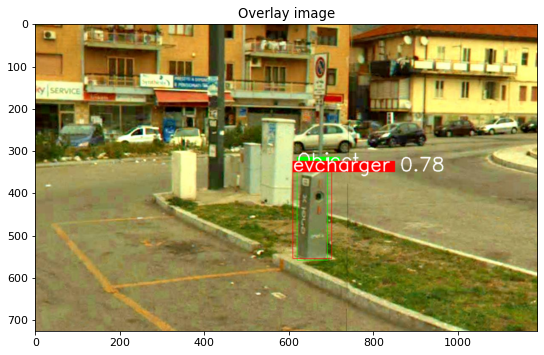

In [9]:
preds = inference(weigths,img)
pred_cords = list()

for bbox in preds:
    cords, conf_score, cls_index = bbox[:4], bbox[4], bbox[5]
    pred_img = plot_boxes(img,cords,score=conf_score,name=cls_name[cls_index],color=(255,0,0))
    pred_cords.append(cords)

plt.figure(figsize=(9,11))
plt.title("Overlay image")
plt.imshow(pred_img)

In [34]:
import torch
import torchvision.ops.boxes as bops

pred_cords = []
for bbox in preds:
    cords, conf_score, cls_index = bbox[:4], bbox[4], bbox[5]
    pred_cords.append(cords)

labels = torch.tensor(labels,dtype=torch.float)
pred_cords = torch.tensor(pred_cords,dtype=torch.float)

print("Box IOU :",round(100* bops.box_iou(pred_cords,labels).numpy()[0][0],2))
print("Genralized Box IOU :",round(100*bops.generalized_box_iou(pred_cords,labels).numpy()[0][0],2))

Box IOU : 74.29
Genralized Box IOU : 72.9


/tmp/ipykernel_8237/3023922084.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels,dtype=torch.float)
